In [55]:
%load_ext autoreload
%autoreload 2

## Shapley value defintion
Given a set of n elements, $U := \{1, \cdots, n\}$ and a function

$g: 2^U \rightarrow \mathbb{R}$ with $g(U) \neq 0$, $g(\varnothing)=0$

define $C(j|T) := g(T \cup \{j\}) - g(T)$ with $T \subseteq U$.

Feture i's contribution:

$\phi_i := \sum_{T \subseteq U} \frac{|T|! (n-1-|T|)!}{n!} C(i|T)$

where
$g(T) := f_T(x_T) - f(x')$ with $f_\varnothing(x_\varnothing) = f(x')$ for some baseline $x'$. 

$f_T(x_T) := \mathbb{E}[ f(x_T, X_{\bar{T}}) | z]$  where $z$ is a hyperparameter

previous approaches considers
- unconditional: $z := \varnothing$
- conditional: $z := \{X_T = x_T \}$

we in addition consider using a causal graph
- do: $z := \{do(X_T = x_T)\}$

## Assumptions
- no unobserved confounders

## Hyper parameters
- dropped_feature_imputation: unconditional, conditional, do 
- timelines: all, last (permutation importance), valid

In [135]:
import networkx as nx
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, check_baseline_target

# Sanity check with linear models

In [129]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = x1 + x2
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    y  = Node('target', lambda x1, x2: x1 + x2, [x1, x2])
    graph = [x1, x2, y]

    # initialize the values from data: now is just specified
    x1.set_baseline_target(0, 1)
    x2.set_baseline_target(0, 1.5)
    y.set_baseline_target(0, 2.5)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=True, nruns=1, permute_edges=True)
graph = build_graph()
cf.run(graph)

outcome additive noise for x2 is 0.5
using order [x1, x2, target]
baselines x1: 0, x2: 0, target: 0
turn on node x1 form 0 to 1
turn on edge x1->target
target changes from 0 to 1
assign 1 credits to x1->target
assign 1 credits to x1->x1
turn on edge x1->x2
x2 changes from 0 to 1
turn on edge x2->target
target changes from 1 to 2
assign 1 credits to x2->target
assign 1 credits to x1->x2
assign 1 credits to x1->x1
turn on node x2 form 1 to 1.5
turn on edge x2->target
target changes from 2 to 2.5
assign 0.5 credits to x2->target
assign 0.5 credits to x2->x2
turn on node target form 2.5 to 2.5
assign 0.0 credits to target->target


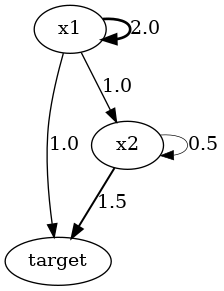

In [130]:
dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

In this example, [x1, x2, target] is the only valid timeline. However, there are 2 paths to the output.

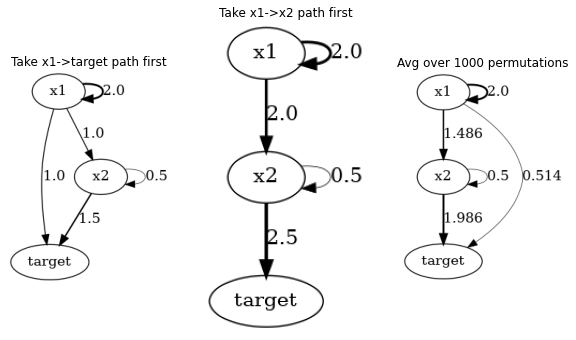

In [141]:
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.title('Take x1->target path first')
plt.imshow(mpimg.imread('figures/graph_correct_order.png'))
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Take x1->x2 path first')
plt.imshow(mpimg.imread('figures/graph_wrong_order.png'))
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Avg over 1000 permutations')
plt.imshow(mpimg.imread('figures/graph_avg_order.png'))
plt.axis('off')
plt.show()

**Observation**: we shouldn't permute the order of edges in this graph because only one order corresponds to intervention in linear models.
The correct order is [y, x1, x2] in this case.

This fixation of order significantly reduces our computational cost (because the number of path could be near exponential, now we just have 1 for each timeline).

Below we show running this algorithm for a more complicated graph.

outcome additive noise for x2 is 0.5
outcome additive noise for x3 is -0.5


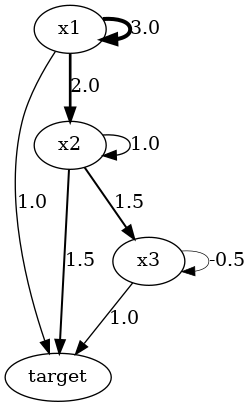

In [143]:
def build_graph2():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    x3 = Node('x3', lambda x2: x2, [x2])
    y  = Node('target', lambda x1, x2, x3: x1 + x2 + x3, [x1, x2, x3])
    graph = [x1, x2, x3, y]

    # initialize the values from data
    x1.set_baseline_target(0, 1)
    x2.set_baseline_target(0, 1.5)
    x3.set_baseline_target(0, 1)
    y.set_baseline_target(0, 3.5)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1)
graph = build_graph2()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')